# 1. Data Gridding with Verde

We are going to grid the data from the previous notebook, and trim down the data in the analysis.

In [1]:
import pandas as pd
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import verde
import verde as vd

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

## Dataset Loading

In [3]:
filename = 'cleaned_geothermal_data.parquet'

df = pd.read_parquet(filename)
print('Dataframe shape', df.shape)
df.head(6)

Dataframe shape (1342867, 22)


,uuid,name,site_name,other_location_name,api,latitude,longitude,state_id,state,state_code,...,bht,max_temperature,depth,shape,datasource,thermal_conductivity,heat_flow,precision_log_source_id,iso_grav,bou_grav
0,525c868b-820a-378a-8202-0bab8ee18479,42135301260000,None,None,42135301260000,31.904,-102.619,15.0,Texas,TX,...,NaN,NaN,1793.75,0101000020E61000000525164298A759C0D28437B57DE7...,MLKay,NaN,NaN,None,NaN,NaN
1,525c9719-b3b8-3a60-9128-55e1fca5092b,42227341000000,None,None,42227341000000,32.115,-101.260,15.0,Texas,TX,...,NaN,NaN,762.00,0101000020E6100000578D6F39A85059C0F5EB9804B90E...,MLKay,NaN,NaN,None,NaN,NaN
2,525c9f62-8700-37a7-bdff-65c314d97bf2,42199322760000,None,None,42199322760000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1232.31,0101000020E61000006A1E7695A49B57C08445459C4E24...,MLKay,NaN,NaN,None,NaN,NaN
3,dcf0c838-7bb5-3453-aace-031d27358123,42199322400000,None,None,42199322400000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1225.91,0101000020E61000005FBEABD4A29B57C0BF0F07095124...,MLKay,NaN,NaN,None,NaN,NaN
4,e93d2d24-4a4d-3e87-a207-3f1f1a9451b8,42199322810000,None,None,42199322810000,30.142,-94.432,15.0,Texas,TX,...,NaN,NaN,1240.23,0101000020E610000069B97DA0A69B57C02ED3E5835424...,MLKay,NaN,NaN,None,NaN,NaN
5,525cae4a-52ed-370d-854c-c2bbfef4057b,42047000500000,None,None,42047000500000,27.253,-98.166,15.0,Texas,TX,...,NaN,NaN,2926.08,0101000020E61000000475CAA39B8A58C09EBBB8E8BF40...,MLKay,NaN,NaN,None,NaN,NaN


## Quick Data Viz

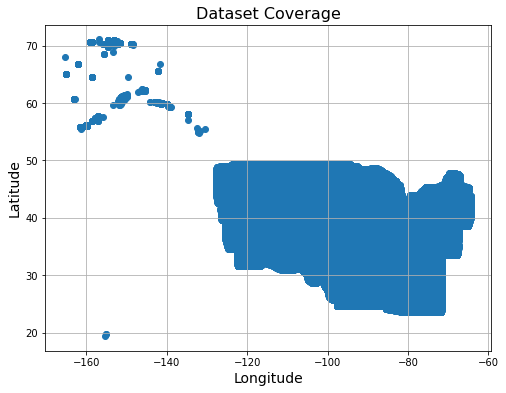

In [4]:
plt.figure(figsize=(8,6))

plt.scatter(df.longitude.values,
            df.latitude.values)

plt.title('Dataset Coverage', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)

plt.grid()

Looks like we have some data in Alaska and Hawai'i, while cool states, the economics are a lot different than the western US. Let's remove these states from the analysis.

Let's drop AK and HI, and only look at western states (-95 and west Longitude)

In [5]:
lat_cutoff = 50
long_cutoff_east = -103
long_cutoff_west = -125

df = df[df.latitude <= lat_cutoff]
df = df[(df.longitude <= long_cutoff_east) & (df.longitude >= long_cutoff_west)]

print('Dataframe shape', df.shape)

Dataframe shape (262750, 22)


Let's make a new plot, and color-code the dot by depth

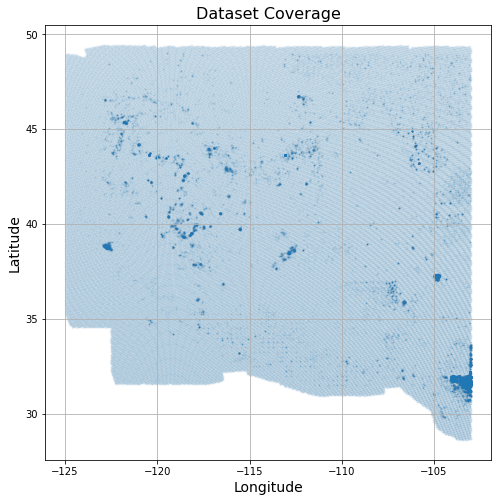

In [6]:
plt.figure(figsize=(8,8))

plt.scatter(df.longitude.values,
            df.latitude.values,
            s=0.9, #size
            alpha=0.05,
            label='Datapoint')

plt.title('Dataset Coverage', size=16)
plt.xlabel('Longitude', size=14)
plt.ylabel('Latitude', size=14)
plt.grid()

Let's look at the range of depths in more detail:

Median Depth 950.98


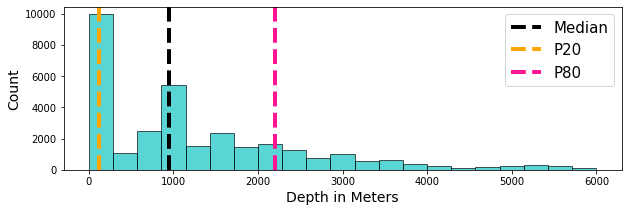

In [7]:
df_depths = df.dropna(subset=['depth'])

plt.figure(figsize=(10,3))

plt.hist(df_depths.depth.values, color='c', edgecolor='k', alpha=0.65, bins=21);
plt.ylabel('Count', size=14)

# add a Median line to the histogram
plt.axvline(np.nanmedian(df_depths.depth.values), color='k', linestyle='dashed', linewidth=4, label='Median')
plt.axvline(np.nanpercentile(df_depths.depth.values, 20, axis=0), color='orange', linestyle='dashed', linewidth=4, label='P20')
plt.axvline(np.nanpercentile(df_depths.depth.values, 80, axis=0), color='deeppink', linestyle='dashed', linewidth=4, label='P80')

plt.xlabel('Depth in Meters', size=14)
plt.legend(prop={'size': 15})

print('Median Depth', np.median(df_depths.depth.values))

## Split into dataframes based on depth

In [8]:
shallow, deep = 200, 2000

In [9]:
df_shallow = df[df.depth < shallow]
df_medium = df[(df.depth >= shallow) & (df.depth <= deep)]
df_deep = df[df.depth > deep]

In [10]:
print('Sanity check:')
print('Shallow, min, max:', df_shallow.depth.min(), df_shallow.depth.max())
print('Medium, min, max:', df_medium.depth.min(), df_medium.depth.max())
print('Deep, min, max:', df_deep.depth.min(), df_deep.depth.max())

Sanity check:
Shallow, min, max: 3.1 199.9
Medium, min, max: 200.0 2000.0
Deep, min, max: 2000.1 5997.55


## Some sample EDA

In [11]:
df_medium.describe()

,latitude,longitude,state_id,county_id,bht,max_temperature,depth,thermal_conductivity,heat_flow,iso_grav,bou_grav
count,15146.000000,15146.000000,15146.000000,15146.000000,6448.000000,2139.000000,15146.000000,6280.000000,6116.000000,17.000000,17.000000
mean,35.657027,-106.293721,18.680378,4001.001717,50.815294,55.976379,1060.089041,2.196742,121.965124,-17.129412,-193.058824
std,5.246483,5.331074,10.929625,1208.446123,31.599576,51.097266,453.229759,0.623816,303.226945,19.421984,74.962049
min,29.322000,-124.354000,6.000000,1309.000000,1.260000,1.710000,200.000000,0.260000,0.000000,-56.300000,-252.000000
25%,31.735000,-106.080750,15.000000,3397.000000,35.600000,21.540000,817.000000,1.738000,53.000000,-26.200000,-252.000000
50%,31.952000,-103.841000,15.000000,4898.000000,46.700000,37.240000,978.400000,2.160000,76.000000,-25.300000,-248.000000
75%,37.869000,-103.104000,16.000000,4915.000000,56.700000,76.650000,1426.725000,2.750000,119.000000,-6.100000,-122.000000
max,48.999000,-103.000000,49.000000,5110.000000,300.000000,300.000000,2000.000000,6.020000,13598.000000,17.900000,-67.000000


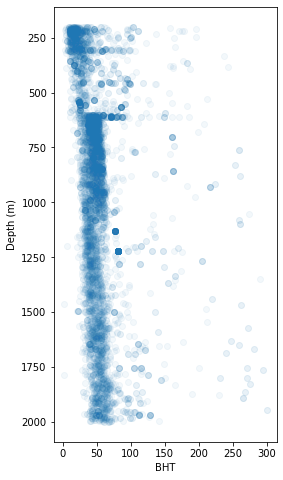

In [12]:
plt.figure(figsize=(4,8))

plt.scatter(df_medium.bht,
            df_medium.depth,
            alpha=0.05)
plt.gca().invert_yaxis()

plt.ylabel('Depth (m)')
plt.xlabel('BHT')
plt.show()

Feel free to change the data frame, scatter plot, etc.

# Verde Gridding

In [13]:
df_medium_explore = df_medium.dropna(subset=['bht'])

In [14]:
spacing = 15 / 60 # Play around with this!

reducer = vd.BlockReduce(reduction=np.median, spacing= spacing)
print(reducer)

BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


In [15]:
filter_coords, filter_data = reducer.filter(
                            coordinates = (df_medium_explore.longitude, 
                                           df_medium_explore.latitude), 
                            data=df_medium_explore.bht)

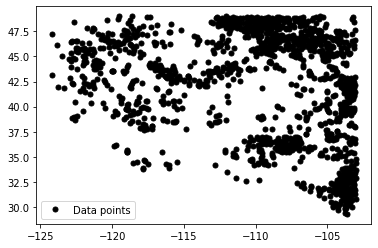

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(*filter_coords, ".k",  markersize=10, label='Data points')
plt.legend()
plt.show()

In [17]:
spline = vd.Spline().fit(filter_coords, filter_data)

region = vd.get_region(filter_coords)
grid_coords = vd.grid_coordinates(region, spacing=spacing)
grid = spline.grid(coordinates=grid_coords, data_names="BHT")
grid

<xarray.Dataset>
Dimensions:   (northing: 80, easting: 86)
Coordinates:
  * easting   (easting) float64 -124.2 -124.0 -123.7 ... -103.5 -103.2 -103.0
  * northing  (northing) float64 29.33 29.58 29.82 30.07 ... 48.5 48.75 49.0
Data variables:
    BHT       (northing, easting) float64 -119.1 -107.4 -95.56 ... 61.64 58.54
Attributes:
    metadata:  Generated by Spline()

In [18]:
distance_mask = 1 #this might not make physical sense
grid = vd.distance_mask(filter_coords, maxdist=distance_mask, grid=grid)

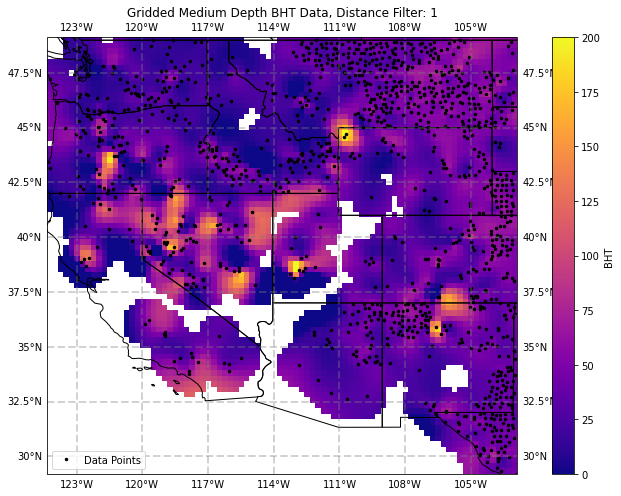

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES)


pc = grid.BHT.plot.pcolormesh(cmap="plasma", add_colorbar=False, vmin=0, vmax=200)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.35, linestyle='--')

plt.colorbar(pc, label='BHT')

plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=5, label='Data Points')

plt.title('Gridded Medium Depth BHT Data, Distance Filter: '+str(distance_mask))

plt.xlabel("West", size=15)
plt.ylabel("North", size=15)
plt.legend()
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()

plt.savefig('example.png', dpi=200)

## Let's do the rest of the variables

In [20]:

def run_block_reduce(dataframe, column, spacing, distance_mask):
    df_ = []
    df_ = dataframe.dropna(subset=[column])
    
    reducer = vd.BlockReduce(reduction=np.median, spacing= spacing)
    print(reducer)
    
    filter_coords, filter_data = reducer.filter(coordinates = (df_.longitude, 
                                                               df_.latitude), 
                                                data=df_[column])
    
    spline = vd.Spline().fit(filter_coords, filter_data)

    region = vd.get_region(filter_coords)
    grid_coords = vd.grid_coordinates(region, spacing=spacing)
    grid = spline.grid(coordinates=grid_coords, data_names=column)
    
    # next line is the one to comment if you do not want a distance mask
    grid = vd.distance_mask(filter_coords, maxdist=distance_mask, grid=grid)
    
    # Let's make a plot
    plt.figure(figsize=(8, 5))
    pc = grid[column].plot.pcolormesh(cmap="plasma", 
                                          add_colorbar=False, 
                                          vmin= int((np.min(df_[column].values))),
                                          vmax= int((np.max(df_[column].values))))

    plt.colorbar(pc)

    plt.plot(filter_coords[0], filter_coords[1], ".k", markersize=5, label='Data Points')
    plt.title('Gridded '+str(column)) #'Distance Filter:'+str(distance_mask))

    plt.xlabel("West", size=15)
    plt.ylabel("North", size=15)
    plt.legend()
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    plt.show()
    print(grid.dims)
    print('       ')
    
    return grid

In [21]:
data = {
    "dataframes" : [df_shallow, df_medium, df_deep],
    "dataframe_names": ['shallow', 'medium', 'deep'], #way to automate this?
    "columns": ['thermal_conductivity','heat_flow','bht', 'max_temperature', 'depth']
}

In [22]:
# Feel free to uncomment if you want a different distance mask from above
distance_mask = 0.8
print('Distance mask value', distance_mask)

Distance mask value 0.8


In [23]:
# Feel free to uncomment if you want a different distance spacing from above
spacing = 15 / 60 # Play around with this! 
print('spacing value', spacing)

spacing value 0.25


In [24]:
!mkdir grids

mkdir: cannot create directory ‘grids’: File exists


shallow
thermal_conductivity
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


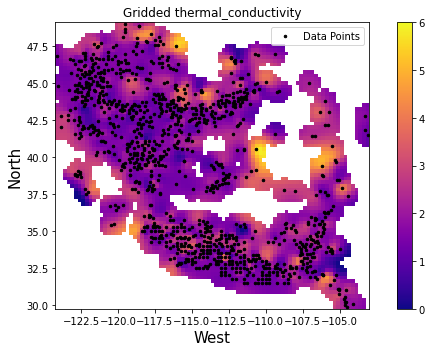

Frozen({'northing': 78, 'easting': 85})
       
shallow_thermal_conductivity.nc
heat_flow
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


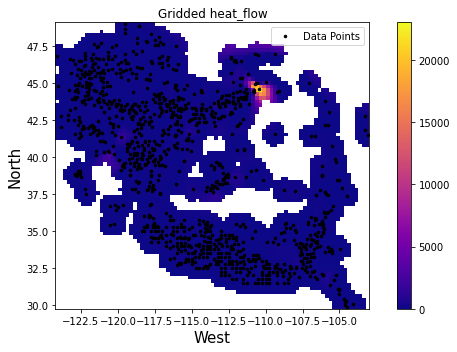

Frozen({'northing': 78, 'easting': 85})
       
shallow_heat_flow.nc
bht
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


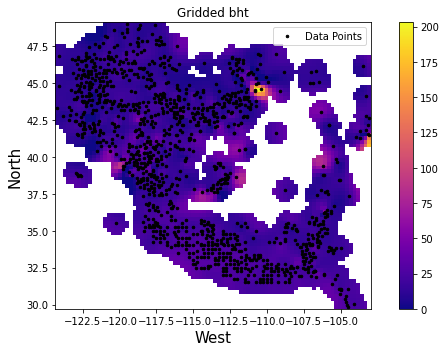

Frozen({'northing': 78, 'easting': 86})
       
shallow_bht.nc
max_temperature
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


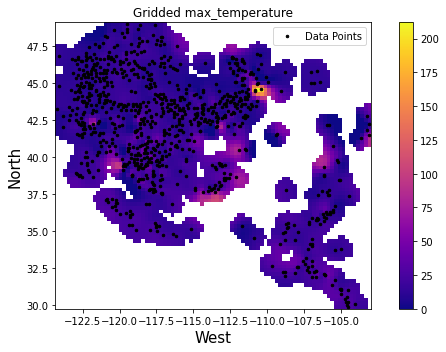

Frozen({'northing': 78, 'easting': 85})
       
shallow_max_temperature.nc
depth
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


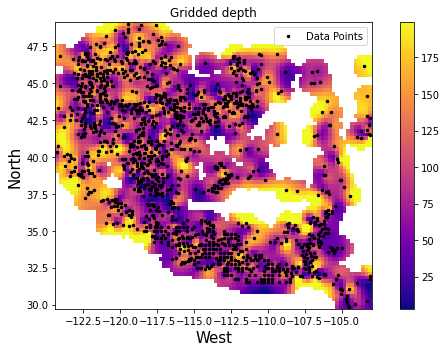

Frozen({'northing': 78, 'easting': 86})
       
shallow_depth.nc
medium
thermal_conductivity
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


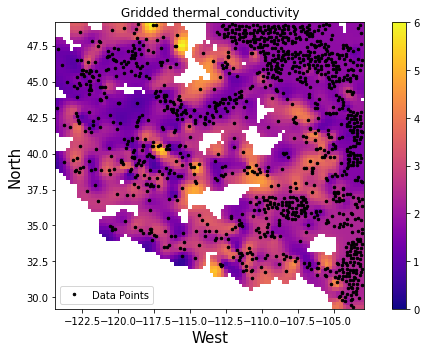

Frozen({'northing': 80, 'easting': 86})
       
medium_thermal_conductivity.nc
heat_flow
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


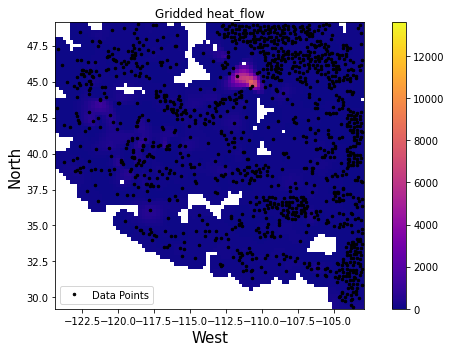

Frozen({'northing': 80, 'easting': 86})
       
medium_heat_flow.nc
bht
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


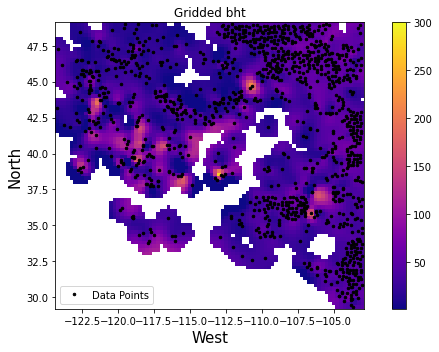

Frozen({'northing': 80, 'easting': 86})
       
medium_bht.nc
max_temperature
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


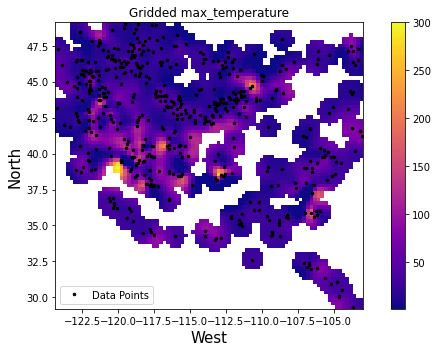

Frozen({'northing': 80, 'easting': 86})
       
medium_max_temperature.nc
depth
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


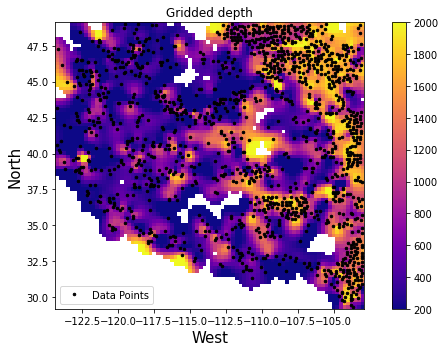

Frozen({'northing': 80, 'easting': 86})
       
medium_depth.nc
deep
thermal_conductivity
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


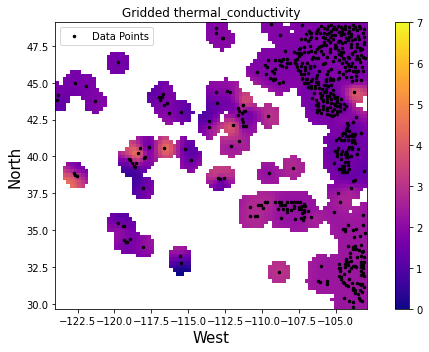

Frozen({'northing': 78, 'easting': 85})
       
deep_thermal_conductivity.nc
heat_flow
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


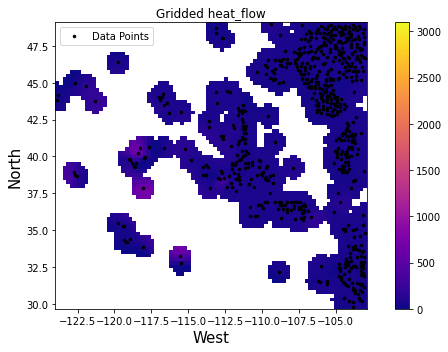

Frozen({'northing': 78, 'easting': 85})
       
deep_heat_flow.nc
bht
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


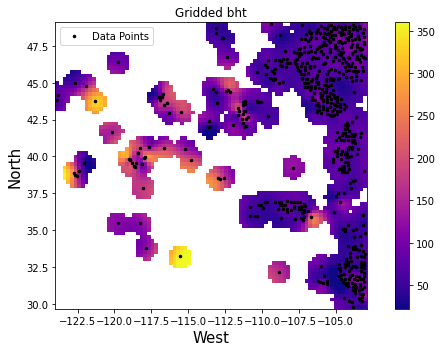

Frozen({'northing': 78, 'easting': 85})
       
deep_bht.nc
max_temperature
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


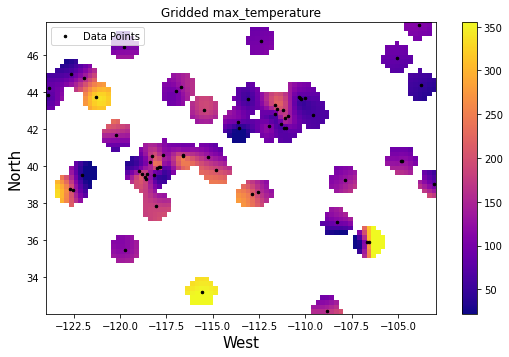

Frozen({'northing': 63, 'easting': 84})
       
deep_max_temperature.nc
depth
BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


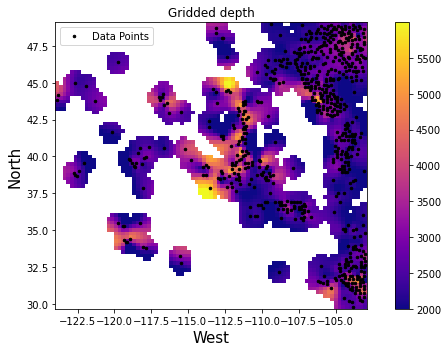

Frozen({'northing': 78, 'easting': 85})
       
deep_depth.nc


In [25]:
for dfs in range(len(data['dataframes'])):
    print(data['dataframe_names'][dfs])
    
    for vars in range(len(data['columns'])):
        print(data['columns'][vars])
        
        ds = run_block_reduce(data['dataframes'][dfs], data['columns'][vars], spacing=spacing, distance_mask=distance_mask)
        
        filename = data['dataframe_names'][dfs] + '_' + data['columns'][vars] + '.nc'
        print(filename)
        ds.to_netcdf('grids/' + filename)

Let's export the gravity to netcdf as well

BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


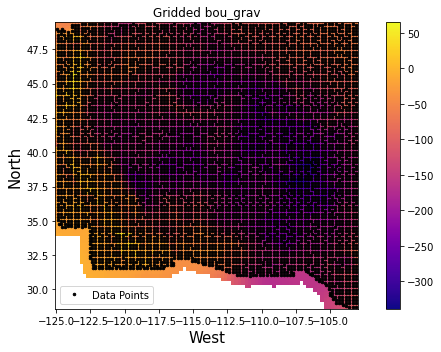

Frozen({'northing': 83, 'easting': 88})
       


In [26]:
ds_bou_grav = run_block_reduce(df, 'bou_grav', spacing= 15 / 60, distance_mask=distance_mask)
ds_bou_grav.to_netcdf('grids/' + 'bou_grav.nc')

BlockReduce(reduction=<function median at 0x7f6aac04a670>, spacing=0.25)


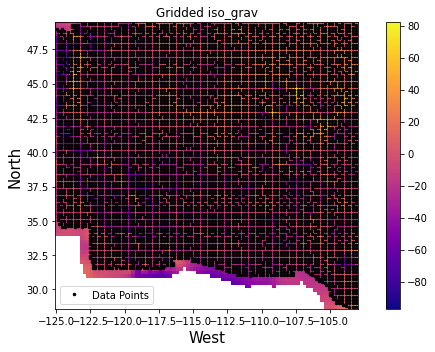

Frozen({'northing': 83, 'easting': 88})
       


In [27]:
ds_iso_grav = run_block_reduce(df, 'iso_grav', spacing= 15 / 60, distance_mask=distance_mask)
ds_iso_grav.to_netcdf('grids/' + 'iso_grav.nc')

Let's double check that we created the files:

In [28]:
!ls grids/

bou_grav.nc		      medium_heat_flow.nc
deep_bht.nc		      medium_max_temperature.nc
deep_depth.nc		      medium_thermal_conductivity.nc
deep_heat_flow.nc	      shallow_bht.nc
deep_max_temperature.nc       shallow_depth.nc
deep_thermal_conductivity.nc  shallow_heat_flow.nc
iso_grav.nc		      shallow_max_temperature.nc
medium_bht.nc		      shallow_thermal_conductivity.nc
medium_depth.nc


Lets clean this up in a new notebook, that focuses on xarray 